In [1]:
import benchmark
from benchmark import Emulator
from benchmark import _read_word as read_word
from benchmark import RAM

In [2]:
import numpy as np

In [3]:
from matplotlib import pyplot as plt

In [4]:
benchmark.MY_MANDELBROT

WindowsPath('C:/Users/peter.russell/Documents/Personal/multiply/Contrib/psr/multiply/mandelbrot/Mandelbrot.gcl')

In [5]:
my_symbols = benchmark._load(benchmark.MY_MANDELBROT)

In [6]:
cycles = benchmark._run_to_main_start()

Boot reached SYS_RESET_88 in 1006781 cycles (0.16108496s)
Boot reached SYS_Exec_88 (Reset) in 1006825 cycles (0.161092s)
Boot reached SYS_Exec_88 (Main) in 2037968 cycles (0.32607488s)
Program was ready to begin exectution after 3752667 cycles (0.60042672s)


In [7]:
cycles += benchmark._run_to_function_entry(my_symbols, 'CalcSet')

In [8]:
pen_address = my_symbols['Pen']
pen_address

58

In [9]:
def get_current_coordinate():
    """Return the current screen coordinate based on the Pen variable"""
    memory_address = read_word(pen_address, signed=False)
    offset_in_screen_ram = memory_address - 0x800
    page, offset_in_page = divmod(offset_in_screen_ram, 0x100)
    return offset_in_page, page

In [10]:
RAM[pen_address:pen_address + 2] = 1,9

In [11]:
get_current_coordinate()

(1, 1)

In [12]:
per_pixel_timings = np.zeros((160, 120), dtype='uint32')

In [13]:
target_vcpu_instruction = Emulator.vLR
f"{target_vcpu_instruction:04x}"

'06ae'

In [14]:
import asm
call_and_a_bit = asm.symbol('CALL') + 1
Emulator.breakpoints.add(call_and_a_bit)

In [15]:
def in_call_instruction():
    return Emulator.next_instruction == call_and_a_bit

def calling_function_of_interest(function_variable):
    return Emulator.AC == function_variable

In [16]:
calc_pixel = my_symbols['CalcPixel']
total_time_in_calc_pixel = 0
count = 0
cycles += Emulator.run_vcpu_to(target_vcpu_instruction)
while in_call_instruction():# and count < 120:
    if not calling_function_of_interest(calc_pixel):
        cycles += Emulator.run_vcpu_to(target_vcpu_instruction)
        continue
    cycles += Emulator.step_vcpu()  # Complete CALL
    
    # We are now at the start of a call to calc_pixel
    return_point = Emulator.vLR
    coords = get_current_coordinate()
    cost_of_calc_pixel = Emulator.run_vcpu_to(return_point)
    # Ignore breakpoint inside function
    while in_call_instruction():
        cost_of_calc_pixel += Emulator.run_vcpu_to(return_point)
    per_pixel_timings[coords] = cost_of_calc_pixel
    total_time_in_calc_pixel += cost_of_calc_pixel
    cycles += cost_of_calc_pixel
    count += 1
    cycles += Emulator.run_vcpu_to(target_vcpu_instruction)

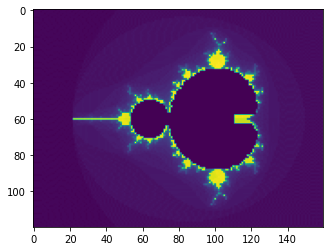

In [17]:
plt.imshow(per_pixel_timings.T)  # Transpose so that the first index is the x-axis.

In [18]:
print(f"total_time_in_calc_pixel: {total_time_in_calc_pixel / cycles * 100:.4}%")

total_time_in_calc_pixel: 81.65%


In [19]:
import matplotlib.colors as colors

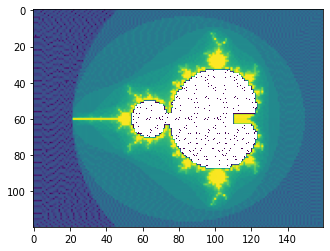

In [20]:
plt.imshow(per_pixel_timings.T, norm=colors.LogNorm())  

In [21]:
from gtemu import RAM
import _gtemu

screen = np.frombuffer(_gtemu.ffi.buffer(RAM), dtype='uint8', offset=0x800).reshape((120, 256))

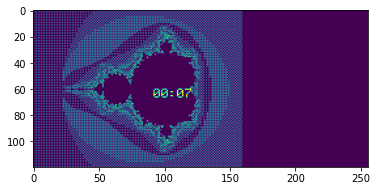

In [22]:
plt.imshow(screen)

In [23]:
print(f"cycles: {cycles}")
print(f"realtime: {cycles * benchmark.CLOCK_PERIOD:.5}s")
mins, secs = divmod(round(cycles * benchmark.CLOCK_PERIOD), 60)
print(f"realtime: {mins}:{secs}")
my_cycles, my_total_time_in_calc_pixel = cycles, total_time_in_calc_pixel
my_timings = per_pixel_timings

cycles: 2708024662
realtime: 433.28s
realtime: 7:13


In [24]:
original_symbols = symbols = benchmark._load(benchmark.ORIGINAL_MANDELBROT)

In [25]:
cycles = benchmark._run_to_main_start()

Boot reached SYS_RESET_88 in 1006781 cycles (0.16108496s)
Boot reached SYS_Exec_88 (Reset) in 1006825 cycles (0.161092s)
Boot reached SYS_Exec_88 (Main) in 2037968 cycles (0.32607488s)
Program was ready to begin exectution after 3961067 cycles (0.63377072s)


In [26]:
cycles += benchmark._run_to_function_entry(symbols, 'CalcSet')

In [27]:
pen_address = symbols['Pen']

def get_current_coordinate():
    """Return the current screen coordinate based on the Pen variable"""
    memory_address = read_word(pen_address, signed=False)
    offset_in_screen_ram = memory_address - 0x800
    page, offset_in_page = divmod(offset_in_screen_ram, 0x100)
    return offset_in_page, page

call_and_a_bit = asm.symbol('CALL') + 1
Emulator.breakpoints.add(call_and_a_bit)

per_pixel_timings = original_per_pixel_timings = np.zeros((160, 120), dtype='uint32')

calc_pixel = symbols['CalcPixel']
total_time_in_calc_pixel = 0
count = 0
cycles += Emulator.run_vcpu_to(target_vcpu_instruction)
while in_call_instruction():# and count < 120:
    if not calling_function_of_interest(calc_pixel):
        cycles += Emulator.run_vcpu_to(target_vcpu_instruction)
        continue
    cycles += Emulator.step_vcpu()  # Complete CALL
    
    # We are now at the start of a call to calc_pixel
    return_point = Emulator.vLR
    coords = get_current_coordinate()
    cost_of_calc_pixel = Emulator.run_vcpu_to(return_point)
    # Ignore breakpoint inside function
    while in_call_instruction():
        cost_of_calc_pixel += Emulator.run_vcpu_to(return_point)
    per_pixel_timings[coords] = cost_of_calc_pixel
    total_time_in_calc_pixel += cost_of_calc_pixel
    cycles += cost_of_calc_pixel
    count += 1
    cycles += Emulator.run_vcpu_to(target_vcpu_instruction)

In [28]:
print(f"cycles: {cycles:,}")
print(f"realtime: {cycles * benchmark.CLOCK_PERIOD:,.6}s")
mins, secs = divmod(round(cycles * benchmark.CLOCK_PERIOD), 60)
print(f"realtime: {mins}:{secs}")
print(f"total_time_in_calc_pixel: {total_time_in_calc_pixel / cycles * 100:.4}%")

cycles: 7,439,242,573
realtime: 1,190.28s
realtime: 19:50
total_time_in_calc_pixel: 90.24%


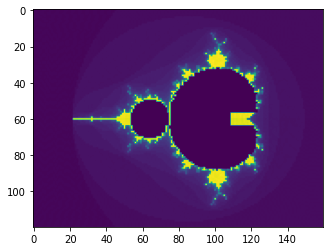

In [29]:
plt.imshow(per_pixel_timings.T)

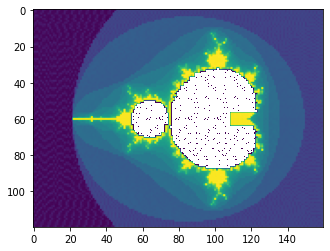

In [30]:
plt.imshow(per_pixel_timings.T, norm=colors.LogNorm())  

In [31]:
time_saved_per_pixel = original_per_pixel_timings.astype('int64') - my_timings
time_saved_per_pixel

array([[ 36342,  52676,  36282, ...,  36282,  45689,  69408],
       [ 64887,  61950,  37950, ...,  58515,  44276,  37094],
       [ 52794,  37150,  45059, ...,  38626,  56319,  37950],
       ...,
       [ 79083, 109721,  99374, ..., 101203, 103278, 101889],
       [112865,  89096, 102853, ...,  97863,  97882,  91509],
       [ 82959, 107653,  90359, ..., 106833,  90513, 104433]], dtype=int64)

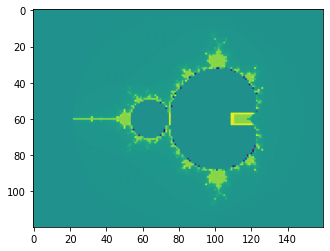

In [32]:
plt.imshow(time_saved_per_pixel.T, norm=colors.TwoSlopeNorm(vcenter=0))

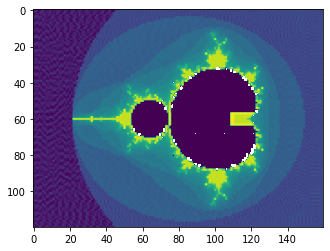

In [33]:
plt.imshow(time_saved_per_pixel.T, norm=colors.LogNorm())

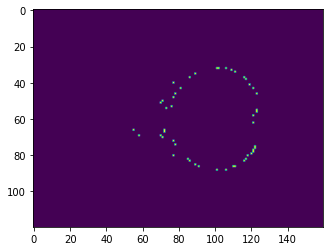

In [35]:
plt.imshow(time_saved_per_pixel.T < 0)